# Introduction to Statistical Learning Exercises 4 - Classification

This post is the fourth in a series where I work through [Intro to Statistical Learning](https://www.statlearning.com/) in python instead of R as done in the text. In this post I'll work through the exercises for chapter 4, on classification. The second edition is coming in summer 2021, but I'm working through the first edition. You can find a free PDF [here](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from IPython.display import display, Markdown
pd.options.display.max_rows = 999
%matplotlib inline

In [2]:
def printm(input_str):
    display(Markdown(input_str))

## 10.

this questions should be answered using the ```Weekly``` data set, which is part of the ```ISLR``` package. This data is similar in nature to the ```Smarket``` data from this chapter's lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1900 to the end of 2010.

In [3]:
df = sm.datasets.get_rdataset("Weekly", "ISLR", cache=True).data

### a)
Produce some numerical and graphical summaries of the ```Weekly``` data. Do there appear to be any patterns?

In [4]:
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [5]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [6]:
df.loc[df["Today"] == 0]

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction


In [7]:
df.loc[df.isna().any(axis=1)]

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction


In [8]:
df.corr().style.background_gradient(cmap='viridis')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


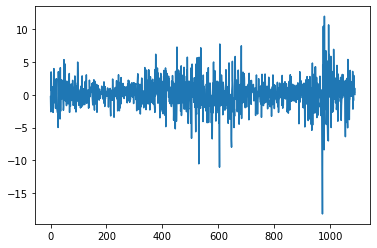

In [9]:
df["Today"].plot();

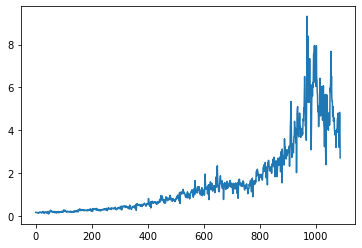

In [10]:
df["Volume"].plot();

Pretty weak correlations, except between volume and year, which we can observe from the above plot is generally trending upward (although declining near the end there.

From looking at the weekly returns plot the series is plausibly stationary. Mean definitely looks stable over time, the volatility might be increasing with time though.

No missing values and the summary statistics all look good. For example, Today and the week lag of today have almost identical summary statistics, as you'd expect for series that are only off by two observations.

### b)

Use the full data set to perform a logistic regression with ```Direction``` as the response and the five lag variables plus ```Volume``` as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [11]:
y = df["Direction"] == "Up"
X = df[[f"Lag{x}" for x in range(1, 6)]]

In [12]:
logit = sm.Logit(y, sm.add_constant(X)).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.682615
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1083
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 May 2021   Pseudo R-squ.:                0.006327
Time:                        17:12:34   Log-Likelihood:                -743.37
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.09186
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2303      0.062      3.712      0.000       0.109       0.352
Lag1          -0.0401      0.

The intercept has a positive and statistically significant coefficient, suggesting returns are slightly more likely to be positive.

Lag 2 is statistically significant and positive (only lag with a positive sign). Implying likelihood of a positive return in the current period increases the more positive returns were two weeks ago.

### c) 

Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

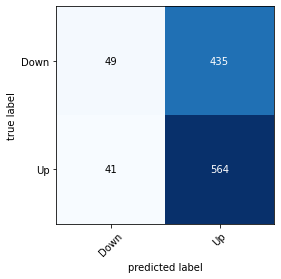

In [13]:
class_labels = ["Down", "Up"] # took the Up dummy column as my independent variable, so 1 = Up
predict_prob = logit.predict(sm.add_constant(X))
predict_class = pd.Series(data=0, index=predict_prob.index)
predict_class.loc[predict_prob > 0.5] = 1 # question didn't specify threshold so let's assume 50%
confusion_mat = confusion_matrix(y, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

In [14]:
accuracy = (predict_class == y).sum() / len(y)
printm(f"Model correctly predicted direction {accuracy:0.1%} of the time")

Model correctly predicted direction 56.3% of the time

The confusion matrix shows that the model is almost exclusively predicting an Up day, regardless of the true outcome. It looks like the positive intercept coefficient is dominating all the other factors in the model. Which is fine given their weak statistical results.

### d)

Now fit the logistic regression model using a training data period from 1990 to 2008, with ```Lag2``` as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data.


In [15]:
df_train = df.loc[df["Year"] <= 2008].copy()
df_test = df.loc[df["Year"] > 2008].copy()
y_train = df_train["Direction"] == "Up"
y_test = df_test["Direction"] == "Up"
X_train = df_train["Lag2"]
X_test = df_test["Lag2"]
logit = sm.Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


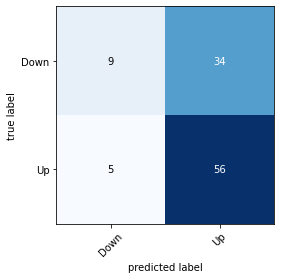

In [16]:
predict_prob = logit.predict(sm.add_constant(X_test))
predict_class = pd.Series(data=0, index=predict_prob.index)
predict_class.loc[predict_prob > 0.5] = 1 # question didn't specify threshold so let's assume 50%
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

### e)

Repeat (d) using LDA

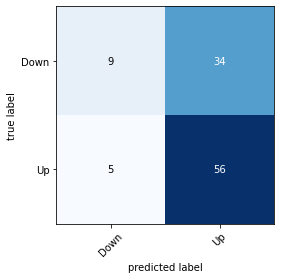

In [17]:
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
predict_class = lda.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

### f)

Repeat (d) using QDA

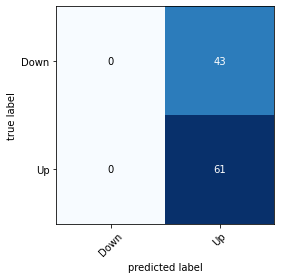

In [18]:

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
predict_class = qda.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

### g)

Repeat (d) using KNN with K=1

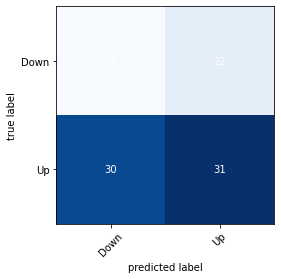

In [19]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
predict_class = knn.predict(X_test)
confusion_mat = confusion_matrix(y_test, predict_class)
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, class_names=class_labels)
plt.show()

### h)

Which of these methods appears to provide the best results on this data?

In [20]:
logit_pred = pd.Series(data=0, index=y_test.index)
logit_pred.loc[logit.predict(sm.add_constant(X_test)) > 0.5] = 1 
lda_pred = lda.predict(X_test)
qda_pred = qda.predict(X_test)
knn_pred = knn.predict(X_test)

logit_accuracy = (logit_pred == y_test).sum() / len(y_test)
lda_accuracy = (lda_pred == y_test).sum() / len(y_test)
qda_accuracy = (qda_pred == y_test).sum() / len(y_test)
knn_accuracy = (knn_pred == y_test).sum() / len(y_test)

printm(f"Logit accuracy: {logit_accuracy:0.1%}, LDA accuracy: {lda_accuracy:0.1%}, QDA accuracy: {qda_accuracy:0.1%}, KNN accuracy: {knn_accuracy:0.1%}")

Logit accuracy: 62.5%, LDA accuracy: 62.5%, QDA accuracy: 58.7%, KNN accuracy: 50.0%

Logit and LDA are tied, with KNN the worst. I don't really trust any of these though.

### i)

Experiment with different combinations of predictors, including possible transformations and interactions for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier

Pass.

## 11.

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the ```Auto``` data set.

### a)

Create a binary variable, ```mpg01```, that contains a 1 if ```mpg``` contains a value above its median, and a 0 if ```mpg``` contains a value below its median.

In [21]:
df = (
    sm.datasets.get_rdataset("Auto", "ISLR", cache=True)
    .data
    .assign(mpg01=lambda df: df["mpg"] > df["mpg"].median())
)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,False
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,False
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,False
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,False
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino,False


### b)

Explore the data graphically in order to investigate the association between ```mpg01``` and the other features. Which of the other features seems most likely to be useful in predicting ```mpg01```? Scatterplots and boxplots are be useful tools to answer this question. Describe your findings.

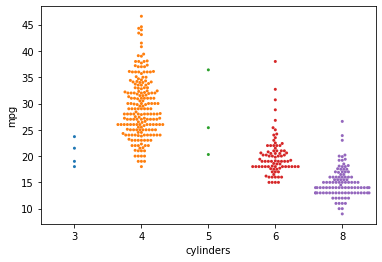

In [22]:
sns.swarmplot(x="cylinders", y="mpg", data=df, size=3);

Increasing cylinders decreases mpg. Looks like there's a wider distribution among 4 cylinders, with fat right tails on 6 and 8. Also worth noting that there are very few 3 and 5 cylinder vehicles, so those categories might have to be collapsed.

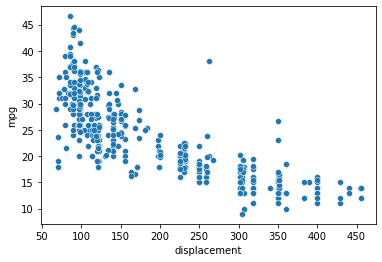

In [23]:
sns.scatterplot(x="displacement", y="mpg", data=df);

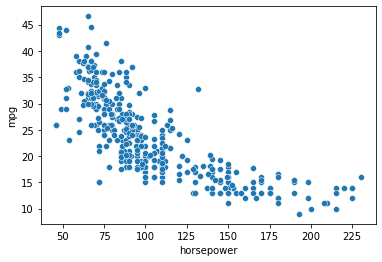

In [24]:
sns.scatterplot(x="horsepower", y="mpg", data=df);

Displacement and horsepower both have a negative and slightly nonlinear looking relationship with mpg. The relationship for both looks quite similar, which makes me wonder if displacement and horsepower are highly correlated.

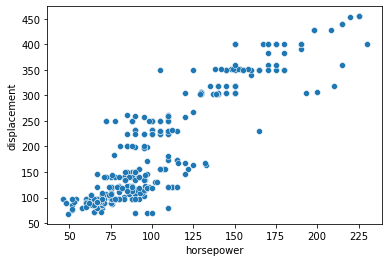

In [25]:
sns.scatterplot(x="horsepower", y="displacement", data=df);

Looks like they are.

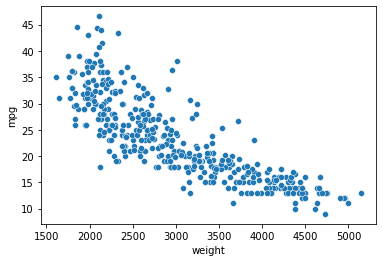

In [26]:
sns.scatterplot(x="weight", y="mpg", data=df);

Weight has a similar looking relationship to displacement and horsepower, although less clearly non-linear.

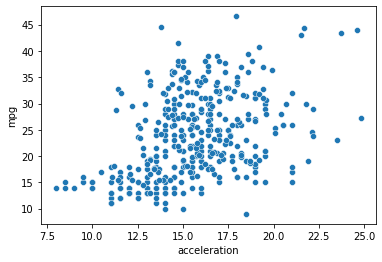

In [27]:
sns.scatterplot(x="acceleration", y="mpg", data=df);

There's a positive association here, but it's a lot weaker than the other variables.

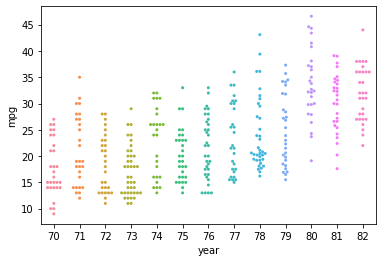

In [28]:
sns.swarmplot(x="year", y="mpg",data=df, size=3);

mpg appears to be improving over time

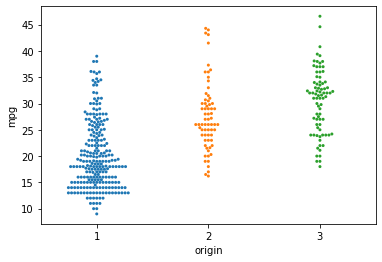

In [29]:
sns.swarmplot(x="origin", y="mpg", size=3, data=df);

1 pretty clearly has a different distribution than 2 and 3, but it's less clear if 2 and 3 are distinct. 3 has the bulk of its distribution above 2, but the min and max are similar and the weights aren't obviously different. Might be worth combining. As a reminder 1 is American, 2 is European and 3 is Japanese.

### c)

Split the data into a training and a test set.

The question doesn't ask but I'm going to do some transformations as well.

In [30]:
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name', 'mpg01'],
      dtype='object')

In [31]:
y = df["mpg01"].values
X = pd.get_dummies(df[["cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"]], columns=["origin"], drop_first=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### d)

Perform LDA on the training data in order to predict ```mpg01``` using the variables that seemed most associated with ```mpg01``` in (b). What is the test error of the model obtained?

In [33]:
subset = ["cylinders", "displacement", "weight", "year", "origin_2", "origin_3"]

In [34]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train[subset], y_train)
y_pred = lda.predict(X_test[subset])
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
printm(f"accuracy: {accuracy:0.7}")
printm(f"f1: {f1:0.7}")

accuracy: 0.8734177

f1: 0.8809524

### e)

Perform QDA on the training data in order to predict ```mpg01``` using the variables that seemed most associated with ```mpg01``` in (b). What is the test error of the model obtained?

In [35]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train[subset], y_train)
y_pred = qda.predict(X_test[subset])
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
printm(f"accuracy: {accuracy:0.7}")
printm(f"f1: {f1:0.7}")

accuracy: 0.8734177

f1: 0.8780488

### f)

Perform Logistic regression on the training data in order to predict ```mpg01``` using the variables that seemed most associated with ```mpg01``` in (b). What is the test error of the model obtained?

In [36]:
logit = LogisticRegression(fit_intercept=True, penalty="none", solver="lbfgs", max_iter=500)
logit.fit(X_train[subset], y_train)
y_pred = logit.predict(X_test[subset])
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
printm(f"accuracy: {accuracy:0.7}")
printm(f"f1: {f1:0.7}")

accuracy: 0.8987342

f1: 0.9

### g)

Perform KNN on the training data, with several values of K, in order to predict ```mpg01```. Use only the variables that seemed most associated with ```mpg01``` in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

In [37]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1,7))}
search = GridSearchCV(knn, param_grid, cv=5)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
y_pred = search.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
printm(f"accuracy: {accuracy:0.7}")
printm(f"f1: {f1:0.7}")

Best parameter (CV score=0.888):
{'n_neighbors': 3}


accuracy: 0.9240506

f1: 0.925

## 12.

This problem involves writing functions.

a) Write a function, ```Power()```, that prints out the result of raising 2 to the 3rd power.
b) Create a new function ```Power2()```, that allows you to pass *any* two numbers ```x``` and ```a```, and prints out the value ```x^a```.
c) Using the ```Power2``` funcion you just wrote compute $10^3$, $8^{17}$, and $131^3$.
d) Now create a new function, ```Power3()```, that actually returns the result ```x^a``` as a ```python``` object.
e) Now using the ```Power3``` function, create a plot of $f(x)=x^2$. The *x*-axis should display a range of integers from 1 to 10, and the *y*-axis should display $x^2$. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the *x*-axis, the *y*-axis, or both on the log-scale.
f) Create a function, ```PlotPower``` that allows you to create a plot of ```x``` against ```x^a``` for a fixed ```a``` and for a range of values of ```x```.

In [38]:
def power3(x, a):
    return x**a

def power2(x, a):
    print(f"{power3(x, a):0,}")

def power():
    power2(2, 3)          

In [39]:
power()

8


In [40]:
for x, a in [(10, 3), (8, 17), (131, 3)]:
    power2(x, a)

1,000
2,251,799,813,685,248
2,248,091


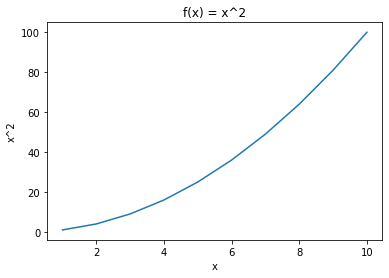

In [41]:
def plot_power(x_min=1, x_max=10, a=2):
    x = np.arange(x_min, x_max + 1, 1)
    y = power3(x, a)
    plt.plot(x, y)
    plt.title(f"f(x) = x^{a}")
    plt.xlabel("x")
    plt.ylabel(f"x^{a}")
    plt.show()
    
plot_power()

## 13.

Using the ```Boston``` data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA,and KNN models using various subsets of the predictors. Describe your findings.

In [42]:
df = sm.datasets.get_rdataset("Boston", "MASS", cache=True).data

In [43]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq ft
* INDUS - proportion of non-retail business acres per town
* CHAS - charles river dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* BLACK - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

In [44]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [45]:
y = df["crim"] > df["crim"].median()
X = df.drop(columns=["crim"])

In [46]:
df.corr().style.background_gradient(cmap='viridis')

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Haven't gotten into cross validation yet so I'm going to do minimal feature selection on this. Everything except chas is reasonably highly correlated with crim. There might be some interaction terms worth exploring but I want to move on with the book rather than spend a bunch of time on this right now. Same with train/test splits and cross validation, that's next chapter.

In [47]:
def evaluate(model, X, y):
    model.fit(X, y)
    print(model.score(X, y))

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1,7))}
search = GridSearchCV(knn, param_grid, cv=5)

models = {"LDA": LinearDiscriminantAnalysis(), "Logit": LogisticRegression(fit_intercept=True, penalty="none", solver="lbfgs", max_iter=10_000), "KNN": search}
for name, model in models.items():
    print(f"Name: {name}")
    print("Score: ")
    evaluate(model, X, y)
    print("------------------")

Name: LDA
Score: 
0.8557312252964426
------------------
Name: Logit
Score: 
0.9150197628458498
------------------
Name: KNN
Score: 
0.9565217391304348
------------------


Dang, KNN crushed it on this one. Maybe with some tuning I could get the others to do better, but that's quite the lead